# Nokappa v3 (LOO) — AUC Evaluation

Predictions from the **40-batch LOO** pipeline (nokappa v3, constant LR 0.1, W=1e-4, 300 ep).

**Pi source**: `enrollment_predictions_nokappa_v3_loo_all40/pi_enroll_fixedphi_sex_FULL.pt`  

**Metrics computed (full 400k):**
1. Static 10-year AUC  
2. Dynamic 10-year AUC  
3. Static 1-year AUC (at enrollment, offset 0)  

**Metrics computed (10k holdout subset):**
4. Rolling 1-year AUC (enrollment + 0 … 9 years)  

Results saved to `claudefile/results_feb18/`.

In [ ]:
import sys, os, gc, warnings
import numpy as np
import pandas as pd
import torch
from pathlib import Path

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

sys.path.insert(0, '/Users/sarahurbut/aladynoulli2/pyScripts')
sys.path.insert(0, '/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision')

from fig5utils import (
    evaluate_major_diseases_wsex_with_bootstrap_from_pi,
    evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi,
)
from evaluatetdccode import evaluate_major_diseases_rolling_1year_roc_curves

# ── Paths ──
DATA_DIR   = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
PI_PATH    = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_nokappa_v3_loo_all40/pi_enroll_fixedphi_sex_FULL.pt')
PCE_PATH   = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv')
RESULTS    = Path('/Users/sarahurbut/aladynoulli2/claudefile/results_feb18')
RESULTS.mkdir(parents=True, exist_ok=True)

N_FULL     = 400_000         # full cohort for static/dynamic AUCs
N_HOLDOUT  = 10_000          # holdout subset for rolling 1yr
N_BOOT     = 100             # bootstrap iterations for CIs

print('Paths configured.  Results →', RESULTS)

Paths configured.  Results → /Users/sarahurbut/aladynoulli2/claudefile/results_feb18


## Load data

In [ ]:
print('Loading pi …')
pi_full = torch.load(PI_PATH, weights_only=False)
print(f'  pi shape: {pi_full.shape}')

print('Loading Y, E, essentials, pce …')
Y_full = torch.load(DATA_DIR / 'Y_tensor.pt',          weights_only=False)
E_full = torch.load(DATA_DIR / 'E_enrollment_full.pt',  weights_only=False)
essentials = torch.load(DATA_DIR / 'model_essentials.pt', weights_only=False)
disease_names = essentials['disease_names']
pce_df_full = pd.read_csv(PCE_PATH)

# Create prevent_impute column (NaN-imputed version of prevent_base_ascvd_risk)
if 'prevent_impute' not in pce_df_full.columns and 'prevent_base_ascvd_risk' in pce_df_full.columns:
    pce_df_full['prevent_impute'] = pce_df_full['prevent_base_ascvd_risk'].fillna(
        pce_df_full['prevent_base_ascvd_risk'].mean())
    print(f'  Created prevent_impute from prevent_base_ascvd_risk '
          f'({pce_df_full["prevent_base_ascvd_risk"].isna().sum()} NAs imputed)')

# Cap to N_FULL
pi_full   = pi_full[:N_FULL]
Y_full    = Y_full[:N_FULL]
E_full    = E_full[:N_FULL]
pce_df_full = pce_df_full.iloc[:N_FULL].reset_index(drop=True)

print(f'\nFull cohort: {N_FULL} individuals')
print(f'  pi  : {pi_full.shape}')
print(f'  Y   : {Y_full.shape}')
print(f'  E   : {E_full.shape}')
print(f'  pce : {len(pce_df_full)} rows')

# Holdout subset for rolling 1yr (first 10k)
pi_holdout      = pi_full[:N_HOLDOUT]
Y_holdout       = Y_full[:N_HOLDOUT]
E_holdout       = E_full[:N_HOLDOUT]
pce_df_holdout  = pce_df_full.iloc[:N_HOLDOUT].reset_index(drop=True)

print(f'\nHoldout subset: {N_HOLDOUT} individuals')
print(f'  pi  : {pi_holdout.shape}')

Loading pi …
  pi shape: torch.Size([400000, 348, 52])
Loading Y, E, essentials, pce …
  Created prevent_impute from prevent_base_ascvd_risk (110457 NAs imputed)

Full cohort: 400000 individuals
  pi  : torch.Size([400000, 348, 52])
  Y   : torch.Size([400000, 348, 52])
  E   : torch.Size([400000, 348])
  pce : 400000 rows

Holdout subset: 10000 individuals
  pi  : torch.Size([10000, 348, 52])


---
## 1. Static 10-year AUC

Uses 1-year risk score at enrollment to predict 10-year outcomes.

In [ ]:
out_static10 = RESULTS / 'static_10yr_results_400k.csv'

if out_static10.exists():
    print(f'Already exists: {out_static10}')
    static10_df = pd.read_csv(out_static10, index_col='Disease')
else:
    print('Computing static 10-year AUCs (400k) …')
    results = evaluate_major_diseases_wsex_with_bootstrap_from_pi(
        pi=pi_full, Y_100k=Y_full, E_100k=E_full,
        disease_names=disease_names, pce_df=pce_df_full,
        n_bootstraps=N_BOOT, follow_up_duration_years=10)
    static10_df = pd.DataFrame({
        'Disease': list(results.keys()),
        'AUC':      [r['auc']        for r in results.values()],
        'CI_lower': [r.get('ci_lower', np.nan) for r in results.values()],
        'CI_upper': [r.get('ci_upper', np.nan) for r in results.values()],
        'N_Events': [r.get('n_events', np.nan) for r in results.values()],
        'Event_Rate': [r.get('event_rate', np.nan) for r in results.values()],
    }).set_index('Disease').sort_values('AUC', ascending=False)
    static10_df.to_csv(out_static10)
    print(f'Saved → {out_static10}')

print('\n=== Static 10-year AUCs — 400k (top 10) ===')
print(static10_df.head(10).to_string())

Already exists: /Users/sarahurbut/aladynoulli2/claudefile/results_feb18/static_10yr_results_400k.csv

=== Static 10-year AUCs — 400k (top 10) ===
                     AUC  CI_lower  CI_upper  N_Events  Event_Rate
Disease                                                           
Heart_Failure   0.758438  0.753339  0.762163      8212     2.05300
ASCVD           0.757341  0.754784  0.760567     34705     8.67625
Atrial_Fib      0.756340  0.752209  0.760324     15278     3.81950
Bladder_Cancer  0.741515  0.731834  0.750013      2158     0.53950
CKD             0.737750  0.732557  0.741941      8980     2.24500
Parkinsons      0.735587  0.724103  0.745833      1839     0.45975
Diabetes        0.730696  0.726884  0.733990     23756     5.93900
All_Cancers     0.716352  0.713077  0.718753     20338     5.08450
Stroke          0.704368  0.696507  0.710168      5686     1.42150
COPD            0.696962  0.693902  0.701215     16789     4.19725


---
## 2. Dynamic 10-year AUC

Cumulative 10-year risk = 1 − ∏(1 − yearly risk).

In [ ]:
out_dyn10 = RESULTS / 'dynamic_10yr_results_400k.csv'

if out_dyn10.exists():
    print(f'Already exists: {out_dyn10}')
    dyn10_df = pd.read_csv(out_dyn10, index_col='Disease')
else:
    print('Computing dynamic 10-year AUCs (400k) …')
    results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi(
        pi=pi_full, Y_100k=Y_full, E_100k=E_full,
        disease_names=disease_names, pce_df=pce_df_full,
        n_bootstraps=N_BOOT, follow_up_duration_years=10)
    dyn10_df = pd.DataFrame({
        'Disease': list(results.keys()),
        'AUC':      [r['auc']        for r in results.values()],
        'CI_lower': [r.get('ci_lower', np.nan) for r in results.values()],
        'CI_upper': [r.get('ci_upper', np.nan) for r in results.values()],
        'N_Events': [r.get('n_events', np.nan) for r in results.values()],
        'Event_Rate': [r.get('event_rate', np.nan) for r in results.values()],
    }).set_index('Disease').sort_values('AUC', ascending=False)
    dyn10_df.to_csv(out_dyn10)
    print(f'Saved → {out_dyn10}')

print('\n=== Dynamic 10-year AUCs — 400k (top 10) ===')
print(dyn10_df.head(10).to_string())

Already exists: /Users/sarahurbut/aladynoulli2/claudefile/results_feb18/dynamic_10yr_results_400k.csv

=== Dynamic 10-year AUCs — 400k (top 10) ===
                      AUC  CI_lower  CI_upper  N_Events  Event_Rate
Disease                                                            
Bladder_Cancer   0.738708  0.730005  0.746482      2158    0.540737
Parkinsons       0.735500  0.727388  0.745725      1839    0.460066
Heart_Failure    0.734219  0.728951  0.738908      8212    2.053021
ASCVD            0.731979  0.729057  0.734585     34704    8.676087
Diabetes         0.730243  0.726791  0.732399     23756    5.939059
Atrial_Fib       0.725031  0.721842  0.729001     15277    3.869417
All_Cancers      0.716154  0.712586  0.720061     20338    5.084551
CKD              0.708443  0.703230  0.713429      8980    2.245022
Prostate_Cancer  0.700270  0.695674  0.704762      7565    4.187447
Stroke           0.694523  0.688559  0.700945      5686    1.421514


---
## 3. Static 1-year AUC (at enrollment)

Uses 1-year risk score at enrollment to predict 1-year outcomes.

In [ ]:
out_static1 = RESULTS / 'static_1yr_results_400k.csv'

if out_static1.exists():
    print(f'Already exists: {out_static1}')
    static1_df = pd.read_csv(out_static1, index_col='Disease')
else:
    print('Computing static 1-year AUCs (400k) …')
    results = evaluate_major_diseases_wsex_with_bootstrap_from_pi(
        pi=pi_full, Y_100k=Y_full, E_100k=E_full,
        disease_names=disease_names, pce_df=pce_df_full,
        n_bootstraps=N_BOOT, follow_up_duration_years=1)
    static1_df = pd.DataFrame({
        'Disease': list(results.keys()),
        'AUC':      [r['auc']        for r in results.values()],
        'CI_lower': [r.get('ci_lower', np.nan) for r in results.values()],
        'CI_upper': [r.get('ci_upper', np.nan) for r in results.values()],
        'N_Events': [r.get('n_events', np.nan) for r in results.values()],
        'Event_Rate': [r.get('event_rate', np.nan) for r in results.values()],
    }).set_index('Disease').sort_values('AUC', ascending=False)
    static1_df.to_csv(out_static1)
    print(f'Saved → {out_static1}')

print('\n=== Static 1-year AUCs — 400k (top 10) ===')
print(static1_df.head(10).to_string())

Already exists: /Users/sarahurbut/aladynoulli2/claudefile/results_feb18/static_1yr_results_400k.csv

=== Static 1-year AUCs — 400k (top 10) ===
                           AUC  CI_lower  CI_upper  N_Events  Event_Rate
Disease                                                                 
Crohns_Disease        0.948352  0.938904  0.959314       110     0.02750
ASCVD                 0.928576  0.922610  0.933775      3268     0.81700
Ulcerative_Colitis    0.917022  0.896923  0.937527       163     0.04075
Colorectal_Cancer     0.899026  0.877898  0.920946       280     0.07000
Atrial_Fib            0.895306  0.882406  0.908400       912     0.22800
Asthma                0.891924  0.884302  0.900373      1928     0.48200
Parkinsons            0.886781  0.856328  0.913544        81     0.02025
Heart_Failure         0.885326  0.863953  0.903587       358     0.08950
Rheumatoid_Arthritis  0.880929  0.854464  0.909761       279     0.06975
Osteoporosis          0.866440  0.841856  0.891732   

---
## 4. Rolling 1-year AUC (enrollment + 0 … 9) — 10k holdout

At each offset year k, predict 1-year risk using pi at time (enrollment + k).  
The same pi tensor is used for all offsets (it already contains predictions at every time step).  
Computed on the **10k holdout subset** (first batch).

In [ ]:
out_rolling = RESULTS / 'rolling_1yr_results_10k.csv'

if out_rolling.exists():
    print(f'Already exists: {out_rolling}')
    rolling_df = pd.read_csv(out_rolling)
else:
    print(f'Computing rolling 1-year AUCs (offsets 0-9) on {N_HOLDOUT} holdout …')

    # Load the 10 per-offset pi tensors (each fitted with data censored at enrollment + k)
    AGE_OFFSET_DIR = '/Users/sarahurbut/Library/CloudStorage/Dropbox/age_offset_nokappa_v3/'
    pi_batches = []
    for k in range(10):
        pi_path = os.path.join(AGE_OFFSET_DIR,
                               f'pi_nokappa_v3_age_offset_{k}_0_10000.pt')
        pi_k = torch.load(pi_path, weights_only=False)
        print(f'  Loaded offset {k}: {pi_path} → {pi_k.shape}')
        pi_batches.append(pi_k)

    rolling_results = evaluate_major_diseases_rolling_1year_roc_curves(
        pi_batches=pi_batches,
        Y_100k=Y_holdout, E_100k=E_holdout,
        disease_names=disease_names, pce_df=pce_df_holdout)

    rows = []
    for disease_group, offset_list in rolling_results.items():
        for k, item in enumerate(offset_list):
            if item is None:
                continue
            fpr, tpr, thresholds, auc_val = item
            rows.append({'Disease': disease_group, 'Offset': k,
                         'AUC': auc_val if auc_val is not None else np.nan})
    rolling_df = pd.DataFrame(rows)
    rolling_df.to_csv(out_rolling, index=False)
    print(f'Saved → {out_rolling}')

print('\n=== Rolling 1-year AUCs — ASCVD by offset (10k holdout) ===')
ascvd_rolling = rolling_df[rolling_df['Disease'] == 'ASCVD'].sort_values('Offset')
print(ascvd_rolling.to_string(index=False))

Already exists: /Users/sarahurbut/aladynoulli2/claudefile/results_feb18/rolling_1yr_results_10k.csv

=== Rolling 1-year AUCs — ASCVD by offset (10k holdout) ===
Disease  Offset      AUC
  ASCVD       0 0.927117
  ASCVD       1 0.913599
  ASCVD       2 0.951090
  ASCVD       3 0.942132
  ASCVD       4 0.935274
  ASCVD       5 0.938249
  ASCVD       6 0.939451
  ASCVD       7 0.934071
  ASCVD       8 0.952446
  ASCVD       9 0.931481


---
## 5. Summary table

In [ ]:
import matplotlib.pyplot as plt

# Reload if needed
static10_df = pd.read_csv(RESULTS / 'static_10yr_results_400k.csv', index_col='Disease')
dyn10_df    = pd.read_csv(RESULTS / 'dynamic_10yr_results_400k.csv', index_col='Disease')
static1_df  = pd.read_csv(RESULTS / 'static_1yr_results_400k.csv', index_col='Disease')
rolling_df  = pd.read_csv(RESULTS / 'rolling_1yr_results_10k.csv')

# Build summary across diseases
diseases_common = sorted(set(static10_df.index) & set(dyn10_df.index) & set(static1_df.index))

summary_rows = []
for d in diseases_common:
    row = {
        'Disease': d,
        'Static_10yr_400k': static10_df.loc[d, 'AUC'] if d in static10_df.index else np.nan,
        'Dynamic_10yr_400k': dyn10_df.loc[d, 'AUC'] if d in dyn10_df.index else np.nan,
        'Static_1yr_400k': static1_df.loc[d, 'AUC'] if d in static1_df.index else np.nan,
    }
    # Add rolling medians (10k holdout)
    dr = rolling_df[rolling_df['Disease'] == d]
    if len(dr) > 0:
        row['Rolling_1yr_10k_median'] = dr['AUC'].median()
        row['Rolling_1yr_10k_min']    = dr['AUC'].min()
        row['Rolling_1yr_10k_max']    = dr['AUC'].max()
    summary_rows.append(row)

summary = pd.DataFrame(summary_rows).set_index('Disease').sort_values('Dynamic_10yr_400k', ascending=False)
summary.to_csv(RESULTS / 'summary_all_metrics.csv')

print('=== Nokappa v3 LOO — AUC Summary ===')
print('  Static/Dynamic 10yr & 1yr: full 400k')
print('  Rolling 1yr offsets 0-9:   10k holdout')
print()
print(summary.round(3).to_string())
print(f'\nMean Static  10yr (400k): {summary["Static_10yr_400k"].mean():.3f}')
print(f'Mean Dynamic 10yr (400k): {summary["Dynamic_10yr_400k"].mean():.3f}')
print(f'Mean Static   1yr (400k): {summary["Static_1yr_400k"].mean():.3f}')
if 'Rolling_1yr_10k_median' in summary.columns:
    print(f'Mean Rolling  1yr (10k, median across offsets): {summary["Rolling_1yr_10k_median"].mean():.3f}')

=== Nokappa v3 LOO — AUC Summary ===
  Static/Dynamic 10yr & 1yr: full 400k
  Rolling 1yr offsets 0-9:   10k holdout

                      Static_10yr_400k  Dynamic_10yr_400k  Static_1yr_400k  Rolling_1yr_10k_median  Rolling_1yr_10k_min  Rolling_1yr_10k_max
Disease                                                                                                                                     
Bladder_Cancer                   0.742              0.739            0.772                   0.804                0.715                0.926
Parkinsons                       0.736              0.736            0.887                   0.897                0.764                0.996
Heart_Failure                    0.758              0.734            0.885                   0.908                0.714                0.928
ASCVD                            0.757              0.732            0.929                   0.937                0.914                0.952
Diabetes                         0.7

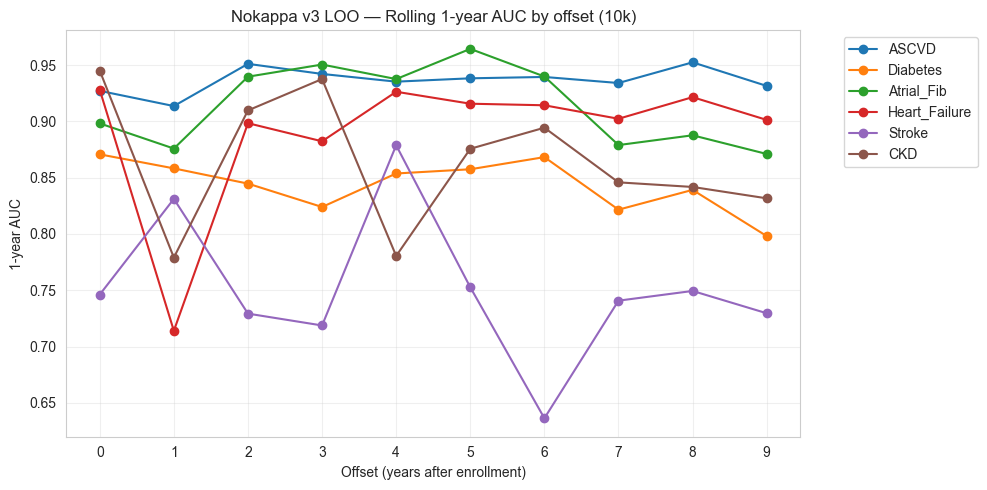

Saved plot → rolling_1yr_auc_key_diseases.pdf


In [ ]:
# Plot: Rolling 1-year AUC across offsets for key diseases
key_diseases = ['ASCVD', 'Diabetes', 'Atrial_Fib', 'Heart_Failure', 'Stroke', 'CKD']

fig, ax = plt.subplots(figsize=(10, 5))
for d in key_diseases:
    sub = rolling_df[rolling_df['Disease'] == d].sort_values('Offset')
    if len(sub) > 0:
        ax.plot(sub['Offset'], sub['AUC'], 'o-', label=d)
ax.set_xlabel('Offset (years after enrollment)')
ax.set_ylabel('1-year AUC')
ax.set_title('Nokappa v3 LOO — Rolling 1-year AUC by offset (10k)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(range(10))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS / 'rolling_1yr_auc_key_diseases.pdf', bbox_inches='tight')
plt.show()
print('Saved plot → rolling_1yr_auc_key_diseases.pdf')

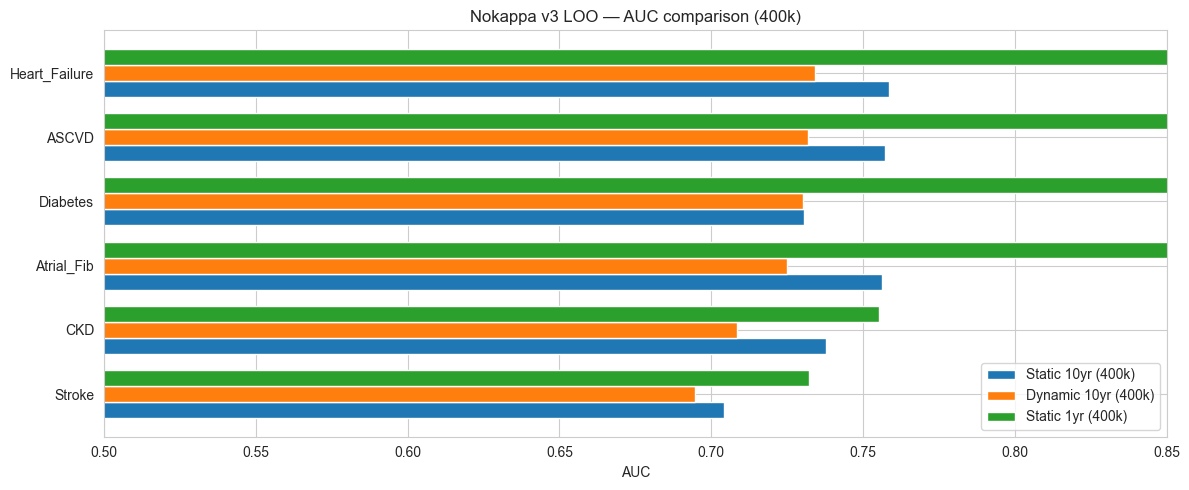

Saved plot → auc_comparison_bar.pdf


In [ ]:
# Bar chart: Static 10yr vs Dynamic 10yr vs Static 1yr for key diseases (400k)
fig, ax = plt.subplots(figsize=(12, 5))
key = summary.loc[summary.index.isin(key_diseases)].sort_values('Dynamic_10yr_400k', ascending=True)
y_pos = np.arange(len(key))
h = 0.25

ax.barh(y_pos - h, key['Static_10yr_400k'],  h, label='Static 10yr (400k)', color='#1f77b4')
ax.barh(y_pos,     key['Dynamic_10yr_400k'], h, label='Dynamic 10yr (400k)', color='#ff7f0e')
ax.barh(y_pos + h, key['Static_1yr_400k'],   h, label='Static 1yr (400k)',  color='#2ca02c')

ax.set_yticks(y_pos)
ax.set_yticklabels(key.index)
ax.set_xlabel('AUC')
ax.set_title('Nokappa v3 LOO — AUC comparison (400k)')
ax.legend()
ax.set_xlim(0.5, 0.85)
ax.axvline(0.5, color='gray', ls='--', alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS / 'auc_comparison_bar.pdf', bbox_inches='tight')
plt.show()
print('Saved plot → auc_comparison_bar.pdf')

---
## Files saved

| File | N | Description |
|------|---|-------------|
| `static_10yr_results_400k.csv` | 400k | Static 10-year AUC per disease (bootstrap CIs) |
| `dynamic_10yr_results_400k.csv` | 400k | Dynamic 10-year AUC per disease (bootstrap CIs) |
| `static_1yr_results_400k.csv` | 400k | Static 1-year AUC per disease (bootstrap CIs) |
| `rolling_1yr_results_10k.csv` | 10k | Rolling 1-year AUC per disease x offset (0-9) |
| `summary_all_metrics.csv` | — | Combined summary table |
| `rolling_1yr_auc_key_diseases.pdf` | — | Rolling 1-year AUC line plot |
| `auc_comparison_bar.pdf` | — | Bar chart comparing metrics |

---
## 6. Delphi Comparison (Nokappa v3)

Compare nokappa v3 predictions against Delphi-2M using the same phecode-based ICD mapping from the original Delphi notebook.

- **t0 comparison**: Our static 1yr AUC (400k) vs Delphi's no-gap AUCs per ICD code
- **1yr comparison**: Our median rolling 1yr AUC (10k, median across offsets 0-9) vs Delphi's no-gap AUCs

In [ ]:
# Load the Delphi ICD-level AUCs from the original comparison (reuse mapping, not our old AUCs)
delphi_t0_path = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/comparisons/pooled_retrospective/delphi_comparison_phecode_mapping_t0_1tomany.csv')
delphi_orig = pd.read_csv(delphi_t0_path)

# Keep only the Delphi columns (drop old Aladynoulli values)
delphi_icd = delphi_orig[['Disease', 'Delphi_t0', 'Delphi_ICD_code', 'Delphi_name']].copy()
print(f'Loaded Delphi ICD-level AUCs: {len(delphi_icd)} rows, {delphi_icd["Disease"].nunique()} diseases')

# --- t0 comparison: nokappa v3 static 1yr (400k) vs Delphi ---
static_1yr = pd.read_csv(RESULTS / 'static_1yr_results_400k.csv')
v3_t0 = static_1yr[['Disease', 'AUC']].rename(columns={'AUC': 'Nokappa_v3_t0'})

comparison_t0 = v3_t0.merge(delphi_icd, on='Disease', how='inner')
comparison_t0['Advantage'] = comparison_t0['Nokappa_v3_t0'] - comparison_t0['Delphi_t0']
comparison_t0 = comparison_t0.sort_values(['Disease', 'Advantage'], ascending=[True, False])

wins_t0 = comparison_t0.groupby('Disease')['Advantage'].apply(lambda x: (x > 0).any())

print(f'\n{"="*80}')
print('NOKAPPA v3 vs DELPHI: t0 PREDICTIONS (1-to-Many)')
print(f'{"="*80}')
print(f'{len(comparison_t0)} comparisons ({comparison_t0["Disease"].nunique()} diseases)')
print(f'Nokappa v3 wins (beats >= 1 Delphi ICD): {wins_t0.sum()}/{len(wins_t0)} diseases ({wins_t0.sum()/len(wins_t0)*100:.1f}%)')
print(f'Mean advantage: {comparison_t0["Advantage"].mean():.4f}')
print(f'Median advantage: {comparison_t0["Advantage"].median():.4f}')

print(f'\n{"-"*80}')
print('ASCVD detail:')
print(comparison_t0[comparison_t0['Disease']=='ASCVD'][['Disease','Nokappa_v3_t0','Delphi_ICD_code','Delphi_t0','Advantage']].to_string(index=False))

# Save
comparison_t0['Win?'] = comparison_t0['Advantage'].apply(lambda x: 'Y' if x > 0 else 'N')
comparison_t0.to_csv(RESULTS / 'delphi_comparison_t0_nokappa_v3.csv', index=False)
print(f'\nSaved -> {RESULTS / "delphi_comparison_t0_nokappa_v3.csv"}')

Loaded Delphi ICD-level AUCs: 82 rows, 28 diseases

NOKAPPA v3 vs DELPHI: t0 PREDICTIONS (1-to-Many)
82 comparisons (28 diseases)
Nokappa v3 wins (beats >= 1 Delphi ICD): 26/28 diseases (92.9%)
Mean advantage: 0.0664
Median advantage: 0.0518

--------------------------------------------------------------------------------
ASCVD detail:
Disease  Nokappa_v3_t0 Delphi_ICD_code  Delphi_t0  Advantage
  ASCVD       0.928576             I21   0.650164   0.278412
  ASCVD       0.928576             I20   0.731225   0.197351
  ASCVD       0.928576             I25   0.823853   0.104723
  ASCVD       0.928576             I51   0.830445   0.098131
  ASCVD       0.928576             I24   0.849424   0.079152
  ASCVD       0.928576             I23   0.896105   0.032471
  ASCVD       0.928576             I22   0.928968  -0.000392

Saved -> /Users/sarahurbut/aladynoulli2/claudefile/results_feb18/delphi_comparison_t0_nokappa_v3.csv


In [ ]:
# --- 1yr comparison: nokappa v3 median rolling 1yr (10k) vs Delphi ---
rolling_1yr = pd.read_csv(RESULTS / 'rolling_1yr_results_10k.csv')
v3_1yr = rolling_1yr.groupby('Disease')['AUC'].median().reset_index()
v3_1yr.columns = ['Disease', 'Nokappa_v3_1yr']

comparison_1yr = v3_1yr.merge(delphi_icd, on='Disease', how='inner')
comparison_1yr = comparison_1yr.rename(columns={'Delphi_t0': 'Delphi_no_gap'})
comparison_1yr['Advantage'] = comparison_1yr['Nokappa_v3_1yr'] - comparison_1yr['Delphi_no_gap']
comparison_1yr = comparison_1yr.sort_values(['Disease', 'Advantage'], ascending=[True, False])

wins_1yr = comparison_1yr.groupby('Disease')['Advantage'].apply(lambda x: (x > 0).any())

print(f'{"="*80}')
print('NOKAPPA v3 vs DELPHI: 1-YEAR PREDICTIONS (1-to-Many)')
print(f'{"="*80}')
print(f'{len(comparison_1yr)} comparisons ({comparison_1yr["Disease"].nunique()} diseases)')
print(f'Nokappa v3 wins (beats >= 1 Delphi ICD): {wins_1yr.sum()}/{len(wins_1yr)} diseases ({wins_1yr.sum()/len(wins_1yr)*100:.1f}%)')
print(f'Mean advantage: {comparison_1yr["Advantage"].mean():.4f}')
print(f'Median advantage: {comparison_1yr["Advantage"].median():.4f}')

print(f'\n{"-"*80}')
print('ASCVD detail:')
print(comparison_1yr[comparison_1yr['Disease']=='ASCVD'][['Disease','Nokappa_v3_1yr','Delphi_ICD_code','Delphi_no_gap','Advantage']].to_string(index=False))

# Save
comparison_1yr['Win?'] = comparison_1yr['Advantage'].apply(lambda x: 'Y' if x > 0 else 'N')
comparison_1yr.to_csv(RESULTS / 'delphi_comparison_1yr_nokappa_v3.csv', index=False)
print(f'\nSaved -> {RESULTS / "delphi_comparison_1yr_nokappa_v3.csv"}')

NOKAPPA v3 vs DELPHI: 1-YEAR PREDICTIONS (1-to-Many)
82 comparisons (28 diseases)
Nokappa v3 wins (beats >= 1 Delphi ICD): 27/28 diseases (96.4%)
Mean advantage: 0.1015
Median advantage: 0.1000

--------------------------------------------------------------------------------
ASCVD detail:
Disease  Nokappa_v3_1yr Delphi_ICD_code  Delphi_no_gap  Advantage
  ASCVD        0.936762             I21       0.650164   0.286598
  ASCVD        0.936762             I20       0.731225   0.205537
  ASCVD        0.936762             I25       0.823853   0.112909
  ASCVD        0.936762             I51       0.830445   0.106317
  ASCVD        0.936762             I24       0.849424   0.087338
  ASCVD        0.936762             I23       0.896105   0.040657
  ASCVD        0.936762             I22       0.928968   0.007794

Saved -> /Users/sarahurbut/aladynoulli2/claudefile/results_feb18/delphi_comparison_1yr_nokappa_v3.csv


In [ ]:
# --- Side-by-side: old (centered) vs new (nokappa v3) vs Delphi ---
# Uses same "beats at least one Delphi ICD" metric as original comparison
old_t0 = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/comparisons/pooled_retrospective/delphi_comparison_phecode_mapping_t0_1tomany.csv')

# Per-disease Delphi stats: min, median, max
delphi_stats = delphi_icd.groupby('Disease')['Delphi_t0'].agg(['min','median','max','count']).reset_index()
delphi_stats.columns = ['Disease', 'Delphi_min', 'Delphi_median', 'Delphi_max', 'N_ICD_codes']

# Old centered model AUCs
old_by_disease = old_t0.groupby('Disease')['Aladynoulli_t0'].first().reset_index().rename(columns={'Aladynoulli_t0': 'Centered_t0'})

# Nokappa v3 AUCs
new_by_disease = v3_t0.copy()

# Merge
three_way = delphi_stats.merge(old_by_disease, on='Disease', how='inner') \
                         .merge(new_by_disease, on='Disease', how='inner')

# "Beats at least one" = our AUC > Delphi_min for that disease
three_way['Centered_beats_any'] = three_way['Centered_t0'] > three_way['Delphi_min']
three_way['v3_beats_any'] = three_way['Nokappa_v3_t0'] > three_way['Delphi_min']
three_way['v3_beats_best'] = three_way['Nokappa_v3_t0'] > three_way['Delphi_max']
three_way['v3_vs_Centered'] = three_way['Nokappa_v3_t0'] - three_way['Centered_t0']
three_way = three_way.sort_values('Nokappa_v3_t0', ascending=False)

print('3-WAY COMPARISON: Nokappa v3 vs Centered vs Delphi (per disease)')
print('='*100)
print(three_way[['Disease', 'N_ICD_codes', 'Delphi_min', 'Delphi_max',
                 'Centered_t0', 'Nokappa_v3_t0', 'v3_vs_Centered',
                 'Centered_beats_any', 'v3_beats_any', 'v3_beats_best']].to_string(index=False))

n = len(three_way)
print(f'\n--- "Beats at least one Delphi ICD code" (same metric as original) ---')
print(f'Centered:   {three_way["Centered_beats_any"].sum()}/{n} ({three_way["Centered_beats_any"].sum()/n*100:.1f}%)')
print(f'Nokappa v3: {three_way["v3_beats_any"].sum()}/{n} ({three_way["v3_beats_any"].sum()/n*100:.1f}%)')
print(f'\n--- "Beats ALL Delphi ICD codes" (hardest bar) ---')
print(f'Nokappa v3: {three_way["v3_beats_best"].sum()}/{n} ({three_way["v3_beats_best"].sum()/n*100:.1f}%)')
print(f'\n--- Nokappa v3 vs Centered ---')
print(f'v3 > Centered: {(three_way["v3_vs_Centered"] > 0).sum()}/{n} ({(three_way["v3_vs_Centered"] > 0).sum()/n*100:.1f}%)')
print(f'Mean improvement: {three_way["v3_vs_Centered"].mean():.4f}')

three_way.to_csv(RESULTS / 'three_way_comparison_t0.csv', index=False)
print(f'\nSaved -> {RESULTS / "three_way_comparison_t0.csv"}')

3-WAY COMPARISON: Nokappa v3 vs Centered vs Delphi (per disease)
             Disease  N_ICD_codes  Delphi_min  Delphi_max  Centered_t0  Nokappa_v3_t0  v3_vs_Centered  Centered_beats_any  v3_beats_any  v3_beats_best
      Crohns_Disease            1    0.814220    0.814220     0.896424       0.948352        0.051928                True          True           True
               ASCVD            7    0.650164    0.928968     0.880921       0.928576        0.047655                True          True          False
  Ulcerative_Colitis            1    0.749907    0.749907     0.816088       0.917022        0.100935                True          True           True
   Colorectal_Cancer            6    0.483427    0.804968     0.825333       0.899026        0.073693                True          True           True
          Atrial_Fib            1    0.672077    0.672077     0.796554       0.895306        0.098752                True          True           True
              Asthma         

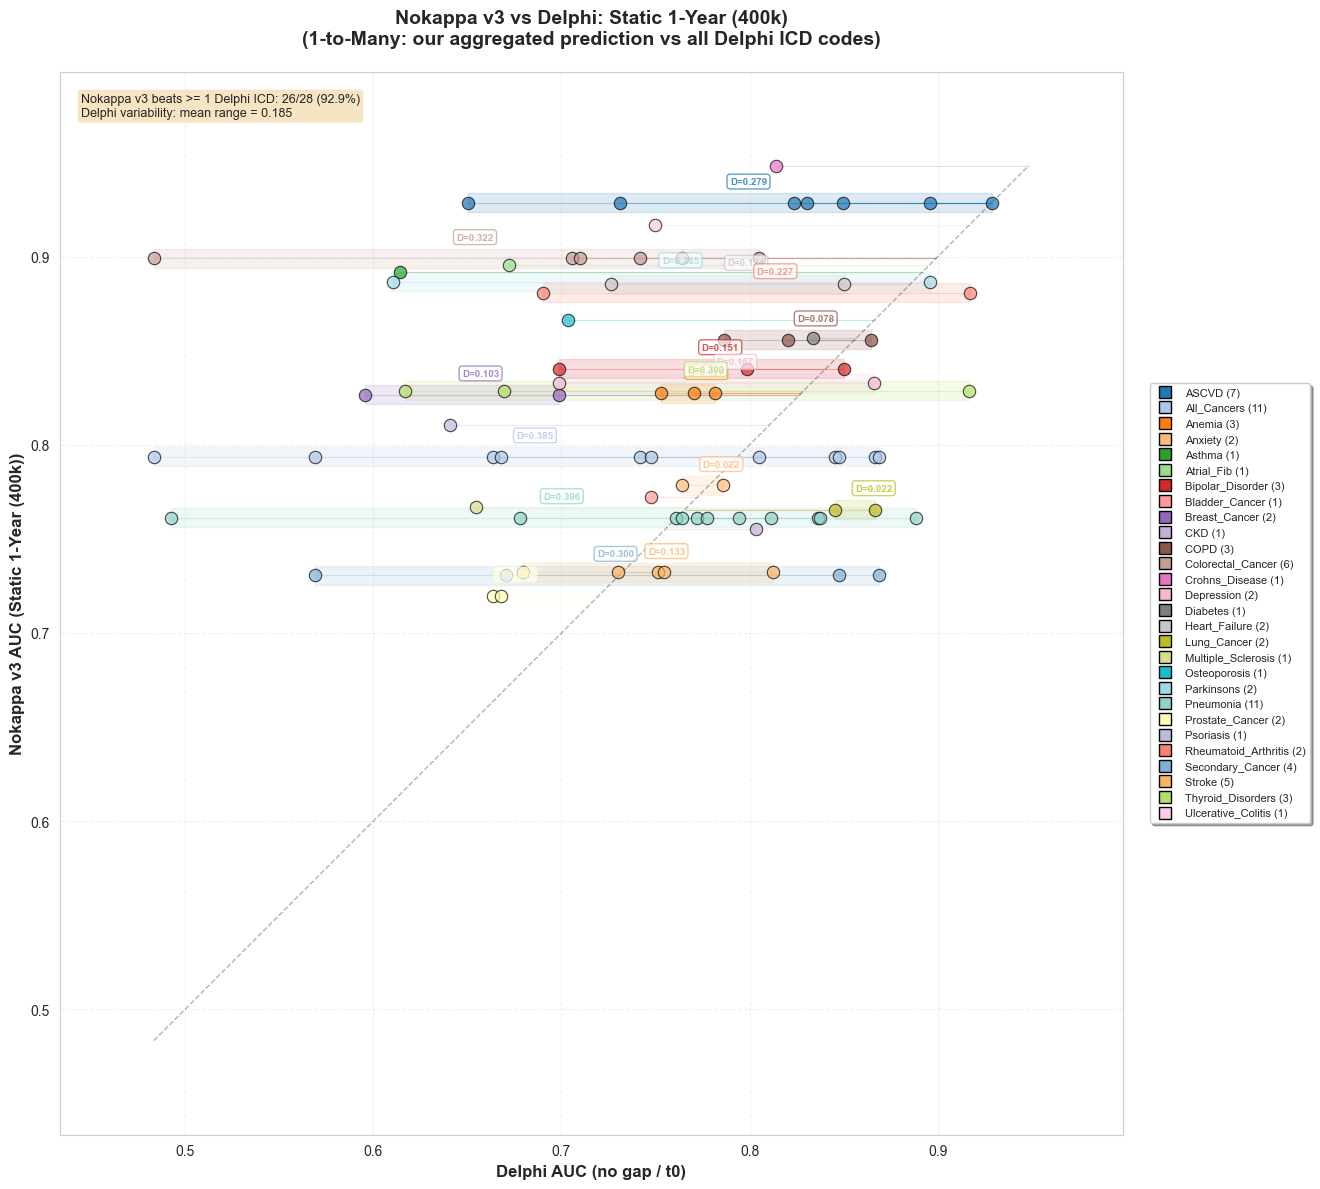

Saved -> /Users/sarahurbut/aladynoulli2/claudefile/results_feb18/delphi_scatter_t0_nokappa_v3.pdf


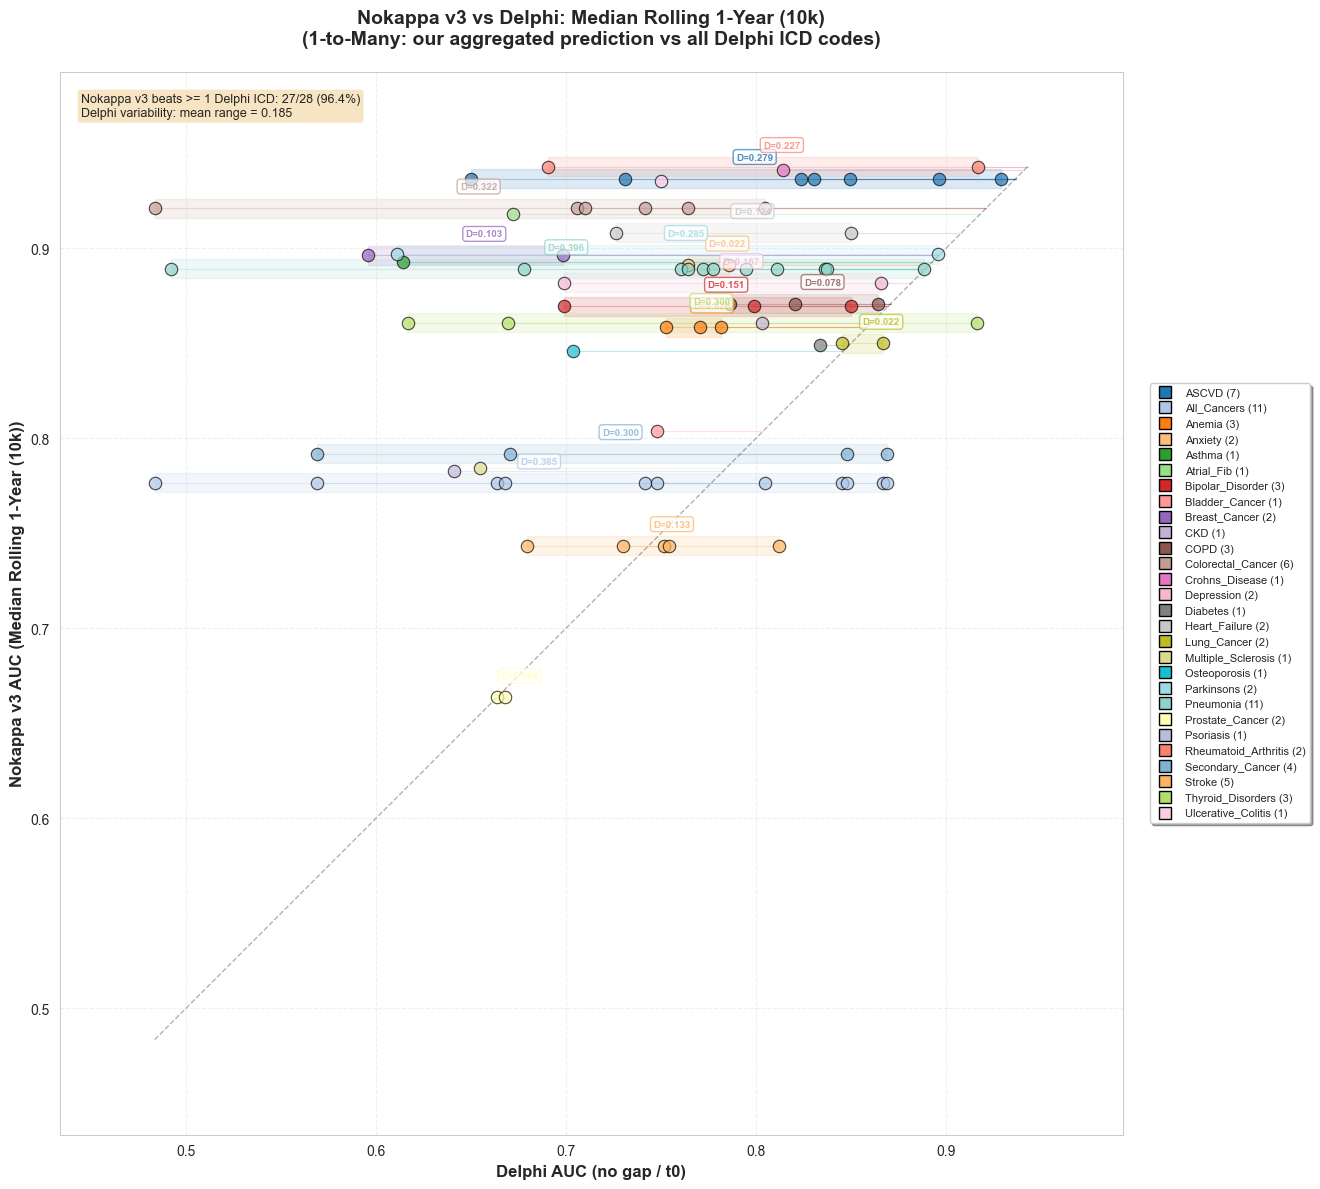

Saved -> /Users/sarahurbut/aladynoulli2/claudefile/results_feb18/delphi_scatter_1yr_nokappa_v3.pdf


In [ ]:
import seaborn as sns

# --- t0 scatter: Nokappa v3 (y) vs Delphi per-ICD (x) ---
sns.set_style("whitegrid")

for comp_df, our_col, delphi_col, title_label, fig_name in [
    (comparison_t0, 'Nokappa_v3_t0', 'Delphi_t0', 'Static 1-Year (400k)', 'delphi_scatter_t0_nokappa_v3.pdf'),
    (comparison_1yr, 'Nokappa_v3_1yr', 'Delphi_no_gap', 'Median Rolling 1-Year (10k)', 'delphi_scatter_1yr_nokappa_v3.pdf'),
]:
    unique_diseases = sorted(comp_df['Disease'].unique())
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    if len(unique_diseases) > 20:
        colors2 = plt.cm.Set3(np.linspace(0, 1, 12))
        colors = np.vstack([colors, colors2])
    disease_colors = {d: colors[i % len(colors)] for i, d in enumerate(unique_diseases)}

    fig, ax = plt.subplots(figsize=(16, 12))

    min_val = min(comp_df[our_col].min(), comp_df[delphi_col].min())
    max_val = max(comp_df[our_col].max(), comp_df[delphi_col].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=1, label='y=x')

    delphi_variability = []

    for disease in unique_diseases:
        dd = comp_df[comp_df['Disease'] == disease]
        our_auc = dd[our_col].iloc[0]
        delphi_aucs = dd[delphi_col].values
        color = disease_colors[disease]

        if len(delphi_aucs) > 1:
            delphi_range = delphi_aucs.max() - delphi_aucs.min()
            delphi_variability.append({'Disease': disease, 'Range': delphi_range,
                                       'Std': delphi_aucs.std(), 'N': len(delphi_aucs)})
            ax.fill_between([delphi_aucs.min(), delphi_aucs.max()],
                           [our_auc - 0.005]*2, [our_auc + 0.005]*2,
                           color=color, alpha=0.15, zorder=0)
            ax.text((delphi_aucs.min()+delphi_aucs.max())/2, our_auc+0.01,
                   f'D={delphi_range:.3f}', fontsize=7, color=color, weight='bold', alpha=0.8, zorder=4,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.7))

        for da in delphi_aucs:
            ax.plot([da, our_auc], [our_auc, our_auc], color=color, alpha=0.3, linewidth=0.8, zorder=1)

        ax.scatter(delphi_aucs, [our_auc]*len(delphi_aucs), s=80, c=[color], marker='o',
                  edgecolors='black', linewidths=0.8, alpha=0.7, zorder=2)

    ax.set_xlabel('Delphi AUC (no gap / t0)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Nokappa v3 AUC ({title_label})', fontsize=12, fontweight='bold')
    ax.set_title(f'Nokappa v3 vs Delphi: {title_label}\n(1-to-Many: our aggregated prediction vs all Delphi ICD codes)',
                fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_aspect('equal', adjustable='box')
    margin = 0.05
    ax.set_xlim([min_val - margin, max_val + margin])
    ax.set_ylim([min_val - margin, max_val + margin])

    legend_elements = [plt.Line2D([0],[0], marker='s', color='w', markerfacecolor=disease_colors[d],
                       markersize=8, markeredgecolor='black', markeredgewidth=1,
                       label=f'{d} ({len(comp_df[comp_df["Disease"]==d])})', linestyle='None')
                      for d in unique_diseases]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5),
             fontsize=8, frameon=True, fancybox=True, shadow=True)

    wins = comp_df.groupby('Disease')['Advantage'].apply(lambda x: (x > 0).any())
    stats_text = f'Nokappa v3 beats >= 1 Delphi ICD: {wins.sum()}/{len(wins)} ({wins.sum()/len(wins)*100:.1f}%)'
    if delphi_variability:
        vdf = pd.DataFrame(delphi_variability)
        stats_text += f'\nDelphi variability: mean range = {vdf["Range"].mean():.3f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.savefig(RESULTS / fig_name, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'Saved -> {RESULTS / fig_name}')